In [2]:
!pip install sqlalchemy
!pip install pyodbc
!pip install statsmodels

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [39]:
from sqlalchemy import create_engine, Table, inspect
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [4]:
def new_engine(dialect, server, database, user=None, password=None, integrated_security=True):
    if integrated_security:
        # For Windows authentication
        eng = f"{dialect}://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
    else:
        # For SQL Server authentication
        eng = f"{dialect}://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
    print(eng)
    return create_engine(eng)

In [5]:
engine = new_engine('mssql', 'UUC-VBA221501J', 'AdventureWorks2022', integrated_security=True)
print(type(engine))

mssql://UUC-VBA221501J/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server
<class 'sqlalchemy.engine.base.Engine'>


In [6]:
connection = engine.connect()
print(type(connection))

<class 'sqlalchemy.engine.base.Connection'>


In [7]:
# Kålla vilken typ av färger det finns.
df = pd.read_sql(sql="SELECT DISTINCT Color FROM Production.Product ", con=connection)
df.head(10)

,Color
0,None
1,Black
2,Blue
3,Grey
4,Multi
5,Red
6,Silver
7,Silver/Black
8,White
9,Yellow


In [17]:
# Analys av Totalt antal beställningar för olika färger
query_1 = """
SELECT A.ProductID, 
       B.Name, 
       B.Color, 
       A.OrderQty
FROM Sales.SalesOrderDetail as A
RIGHT JOIN Production.Product AS B
    ON A.ProductID = B.ProductID
WHERE B.color IS NOT NULL
ORDER BY ProductID ASC;
"""

Color
Black           81937.0
Blue            23659.0
Grey                0.0
Multi           25073.0
Red             29229.0
Silver          25023.0
Silver/Black     3931.0
White            5217.0
Yellow          32556.0
Name: OrderQty, dtype: float64


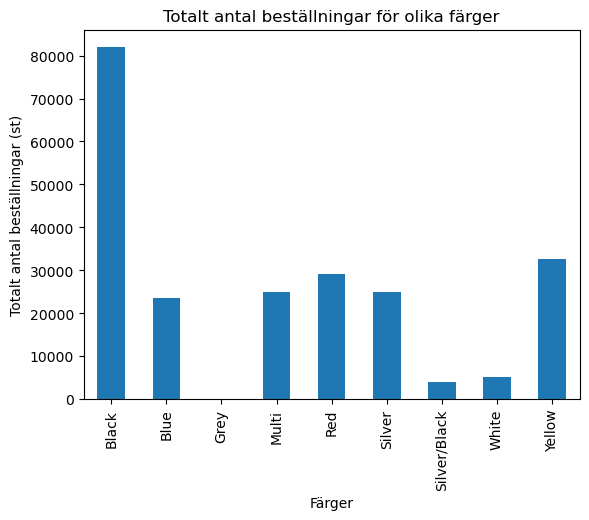

In [18]:
# Hämta datan fråm SQL resultatet
df_tolorderQty = pd.read_sql(query_1, con=connection)

# Analysera datan
Color_distribution = df_tolorderQty.groupby('Color')['OrderQty'].sum()
print(Color_distribution)

# Visualisera datan
Color_distribution.plot(kind='bar')
plt.title('Totalt antal beställningar för olika färger')
plt.xlabel('Färger')
plt.ylabel('Totalt antal beställningar (st)')
plt.show()

In [19]:
# Analys av Totalt priset för olika färger
query_2 = """
SELECT A.ProductID, 
       B.Name, 
       B.Color, 
       A.OrderQty, 
       A.OrderQty*A.UnitPrice AS Price
FROM Sales.SalesOrderDetail as A
RIGHT JOIN Production.Product AS B
    ON A.ProductID = B.ProductID
WHERE B.color IS NOT NULL
ORDER BY ProductID ASC;
"""

Color
Black           3.836016e+07
Blue            9.661163e+06
Grey            0.000000e+00
Multi           6.524005e+05
Red             2.166004e+07
Silver          1.986666e+07
Silver/Black    1.475309e+05
White           3.002943e+04
Yellow          1.889371e+07
Name: Price, dtype: float64


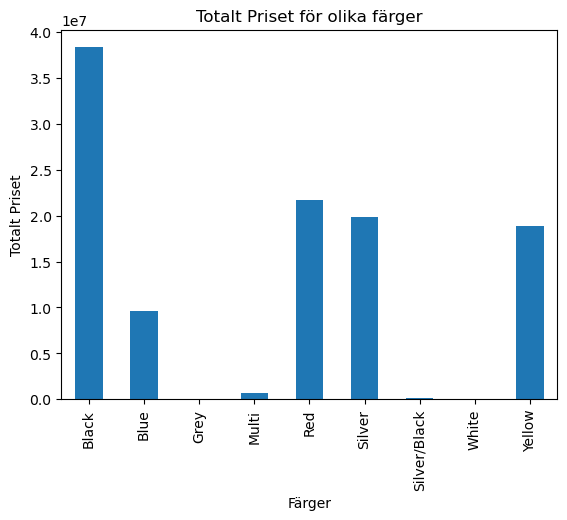

In [20]:
# Hämta datan fråm SQL resultatet
df_tolPrice = pd.read_sql(query_2, con=connection)

# Analysera datan
Color_distribution = df_tolPrice.groupby('Color')['Price'].sum()
print(Color_distribution)

# Visualisera datan
Color_distribution.plot(kind='bar')
plt.title('Totalt Priset för olika färger')
plt.xlabel('Färger')
plt.ylabel('Totalt Priset')
plt.show()

In [21]:
# Användning av en CTE för att beräkna det totala priset per varje beställning, totala orderns kvantitet och prisbelopp för varje olika färg
# Här behöver göra några gånger för att hämta datan på varje färg
query_3_cte_color = """
WITH ProductCTE (ProductID, Name, ProductNumber, Color)
AS (
SELECT ProductID, Name, ProductNumber, Color
FROM Production.Product
WHERE Color = 'Yellow'
)

SELECT A.ProductID, 
       B.Name, 
       B.ProductNumber, 
       B.Color, 
       A.OrderQty, 
       A.UnitPrice, 
       A.OrderQty*A.UnitPrice AS TolPricePOder, 
       SUM(A.OrderQty) OVER () AS TolOrderQty,
       SUM(A.OrderQty*A.UnitPrice) OVER () AS AmountPrice
FROM Sales.SalesOrderDetail as A
INNER JOIN ProductCTE AS B
    ON A.ProductID = B.ProductID
ORDER BY ProductID ASC;

"""

In [22]:
# Hämta datan
result = pd.read_sql(query_3_cte_color, engine)
result.head(1000)

,ProductID,Name,ProductNumber,Color,OrderQty,UnitPrice,TolPricePOder,TolOrderQty,AmountPrice
0,797,"Road-550-W Yellow, 38",BK-R64Y-38,Yellow,4,600.2625,2401.0500,32556,1.889371e+07
1,797,"Road-550-W Yellow, 38",BK-R64Y-38,Yellow,6,600.2625,3601.5750,32556,1.889371e+07
2,797,"Road-550-W Yellow, 38",BK-R64Y-38,Yellow,7,600.2625,4201.8375,32556,1.889371e+07
3,797,"Road-550-W Yellow, 38",BK-R64Y-38,Yellow,3,600.2625,1800.7875,32556,1.889371e+07
4,797,"Road-550-W Yellow, 38",BK-R64Y-38,Yellow,2,600.2625,1200.5250,32556,1.889371e+07
...,...,...,...,...,...,...,...,...,...
995,798,"Road-550-W Yellow, 40",BK-R64Y-40,Yellow,3,672.2940,2016.8820,32556,1.889371e+07
996,798,"Road-550-W Yellow, 40",BK-R64Y-40,Yellow,1,672.2940,672.2940,32556,1.889371e+07
997,798,"Road-550-W Yellow, 40",BK-R64Y-40,Yellow,2,672.2940,1344.5880,32556,1.889371e+07
998,798,"Road-550-W Yellow, 40",BK-R64Y-40,Yellow,3,672.2940,2016.8820,32556,1.889371e+07


In [23]:
# Spara DataFrame
result.to_csv('Yellow_data.csv', index=False)

In [24]:
# Beräkna_1 konfidensintervallet för genomsnittlig kvantitet för varje order av olika färger.
Ave_QtyPorder = result.OrderQty
ci_Ave_QtyPorder = stats.norm.interval(0.95, loc=np.mean(Ave_QtyPorder), scale=stats.sem(Ave_QtyPorder))
print(f"Confidence Interval for Average quanty of each Order of every different color': {ci_Ave_QtyPorder}")
print(f"The total Order Quanty': {result.TolOrderQty.unique()[0]}")

Confidence Interval for Average quanty of each Order of every different color': (2.4862778862673958, 2.5760763354710585)
The total Order Quanty': 32556


In [25]:
# Beräkna_2 konfidensintervallet för genomsnittlig Enhetspris av olika färger.
Ave_UnitPrice = result.UnitPrice
ci_Ave_UnitPrice = stats.norm.interval(0.95, loc=np.mean(Ave_UnitPrice), scale=stats.sem(Ave_UnitPrice))
print(f"Confidence Interval for Average Unit Price of every different color': {ci_Ave_UnitPrice}")

Confidence Interval for Average Unit Price of every different color': (720.8239280823635, 742.2179335876723)


In [26]:
# Beräkna_3 konfidensintervallet för det genomsnittliga priset för varje order av varje olika färg.

AvePricePOder = result.TolPricePOder
ci_AvePricePOder = stats.norm.interval(0.95, loc=np.mean(AvePricePOder), scale=stats.sem(AvePricePOder))
print(f"Confidence Interval for Average Price of each Order of every different color': {ci_AvePricePOder}")
print(f"The Amount price of the total order': {result.AmountPrice.unique()[0]}")

Confidence Interval for Average Price of each Order of every different color': (1438.1280976707048, 1499.7834622111177)
The Amount price of the total order': 18893709.2416


In [27]:
# Samla datan för varje färg
data1 = {'Color':['Red', 'Black', 'Blue', 'Multi', 'Silver', 'White', 'Yellow'],
         'Tolal_Order_Quantity':['29229', '81937', '23659', '25073', '25023', '5217', '32556'],
         'Lower_Ci_AveQtyPorder':['2.2008400189949584', '2.689936910404909', '2.552528278730763', '2.8835531113706505', '2.3099429329769765', '3.439515624779226', '2.4862778862673958'],
         'Higher_Ci_AveQtyPorder':['2.27355722555154', '2.7545629068647672', '2.6794487225960837', '3.0145885023672934', '2.387447718421559', '3.862093892365631', '2.5760763354710585'],
         'Lower_Ci_AveUPrice':['970.1179150511022', '601.0248365872461', '520.3142876993127', '26.710419038050016', '919.5913635728369', '6.762517748008326', '720.8239280823635'],
         'Higher_Ci_AveUPrice':['1009.753623548209', '618.1640881345053', '548.5473205934779', '27.47641803557973', '952.6142655993048', '6.943142014063053', '742.2179335876723'],
         'Lower_Ci_AvePricePOder':['1626.367361487639', '1252.2706705545065', '1030.6130184158326', '74.71847069451005', '1819.0822827576108', '19.97532470035816', '1438.1280976707048'],
         'Higher_Ci_AvePricePOder':['1689.3675026685025', '1296.6617081557492', '1105.867066789828', '78.75141399144619', '1910.344368209162', '22.05326284337872', '1499.7834622111177'],
         'Total_Price':['21660038.0001', '38360157.8334', '9661162.9453', '652400.4798', '19866655.7697', '30029.4258', '18893709.2416']
  }

# Skapa en DataFrame baserat på ovanstående resultat som samlats in för varje färg."
df1 = pd.DataFrame(data=data1)
# Visa innehållet i DataFrame df1.
df1

# Save the DataFrame df1
#df1.to_csv('Analysis data with Ci.csv', index=False)

,Color,Tolal_Order_Quantity,Lower_Ci_AveQtyPorder,Higher_Ci_AveQtyPorder,Lower_Ci_AveUPrice,Higher_Ci_AveUPrice,Lower_Ci_AvePricePOder,Higher_Ci_AvePricePOder,Total_Price
0,Red,29229,2.2008400189949584,2.27355722555154,970.1179150511022,1009.753623548209,1626.367361487639,1689.3675026685025,21660038.0001
1,Black,81937,2.689936910404909,2.7545629068647672,601.0248365872461,618.1640881345053,1252.2706705545065,1296.6617081557492,38360157.8334
2,Blue,23659,2.552528278730763,2.6794487225960837,520.3142876993127,548.5473205934779,1030.6130184158326,1105.867066789828,9661162.9453
3,Multi,25073,2.8835531113706505,3.0145885023672934,26.710419038050016,27.47641803557973,74.71847069451005,78.75141399144619,652400.4798
4,Silver,25023,2.3099429329769765,2.387447718421559,919.5913635728369,952.6142655993048,1819.0822827576108,1910.344368209162,19866655.7697
5,White,5217,3.439515624779226,3.862093892365631,6.762517748008326,6.943142014063053,19.97532470035816,22.05326284337872,30029.4258
6,Yellow,32556,2.4862778862673958,2.5760763354710585,720.8239280823635,742.2179335876723,1438.1280976707048,1499.7834622111177,18893709.2416


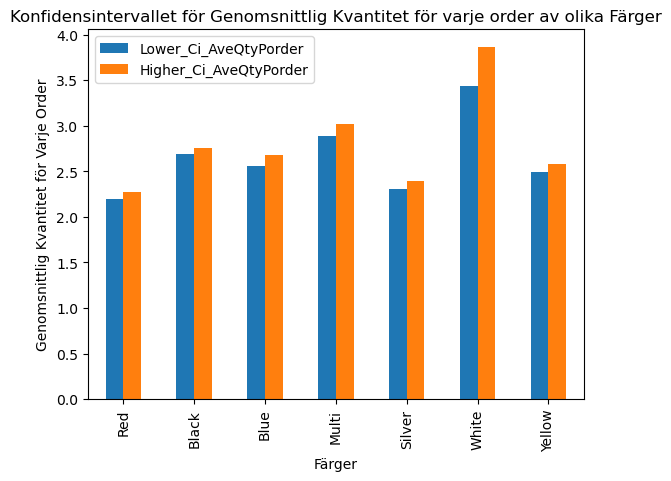

In [28]:
# Converting columns to numeric
df1['Tolal_Order_Quantity'] = pd.to_numeric(df1['Tolal_Order_Quantity'])
df1['Lower_Ci_AveQtyPorder'] = pd.to_numeric(df1['Lower_Ci_AveQtyPorder'])
df1['Higher_Ci_AveQtyPorder'] = pd.to_numeric(df1['Higher_Ci_AveQtyPorder'])
df1['Lower_Ci_AveUPrice'] = pd.to_numeric(df1['Lower_Ci_AveUPrice'])
df1['Higher_Ci_AveUPrice'] = pd.to_numeric(df1['Higher_Ci_AveUPrice'])
df1['Lower_Ci_AvePricePOder'] = pd.to_numeric(df1['Lower_Ci_AvePricePOder'])
df1['Higher_Ci_AvePricePOder'] = pd.to_numeric(df1['Higher_Ci_AvePricePOder'])
df1['Total_Price'] = pd.to_numeric(df1['Total_Price'])

# Visualisera_1 konfidensintervallet för genomsnittlig kvantitet för varje order av olika färger.
Ci_AveQtyPorder = df1.plot(kind='bar', x='Color', y=['Lower_Ci_AveQtyPorder', 'Higher_Ci_AveQtyPorder'])

plt.title('Konfidensintervallet för Genomsnittlig Kvantitet för varje order av olika Färger')
plt.xlabel('Färger')
plt.ylabel('Genomsnittlig Kvantitet för Varje Order')

plt.show()


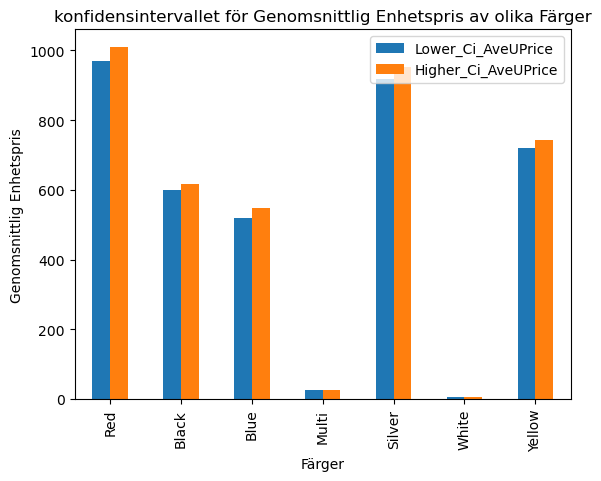

In [29]:
# Visualisera_2 konfidensintervallet för genomsnittlig kvantitet för varje order av olika färger.
Ci_AveUPrice = df1.plot(kind='bar', x='Color', y=['Lower_Ci_AveUPrice', 'Higher_Ci_AveUPrice'])
plt.title('konfidensintervallet för Genomsnittlig Enhetspris av olika Färger')
plt.xlabel('Färger')
plt.ylabel('Genomsnittlig Enhetspris')
plt.show()

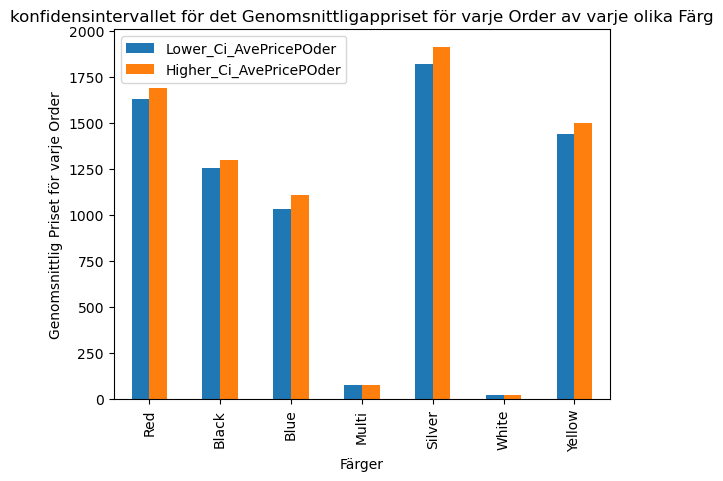

In [30]:
# Visualisera_3 konfidensintervallet för det genomsnittliga priset för varje order av varje olika färg.
Ci_AvePricePOder = df1.plot(kind='bar', x='Color', y=['Lower_Ci_AvePricePOder', 'Higher_Ci_AvePricePOder'])
plt.title('konfidensintervallet för det Genomsnittligappriset för varje Order av varje olika Färg')
plt.xlabel('Färger')
plt.ylabel('Genomsnittlig Priset för varje Order')
plt.show()

In [40]:
# Räkna antalet beställningar för varje produktion med varje färg
# Här behöver göra några gånger för att hämta datan på varje färg

query_5_cte_sql_color_productions = """
WITH productCTE (ProductID, Name, ProductNumber, Color)
AS (
SELECT ProductID, Name, ProductNumber, Color
FROM Production.Product
WHERE Color = 'Blue'
)

SELECT  COUNT(CASE WHEN B.Name LIKE '%Sport-100 Helmet%' THEN '1' END) 'Sport-100 Helmet',
        COUNT(CASE WHEN B.Name LIKE '%Road%' THEN '1' END) 'Road',
        COUNT(CASE WHEN B.Name LIKE '%Mountain%' THEN '1' END) 'Mountain',
        COUNT(CASE WHEN B.Name LIKE '%Crankset%' THEN '1' END) 'Crankset',
        COUNT(CASE WHEN B.Name LIKE '%Gloves%' THEN '1' END) 'Finger',
        COUNT(CASE WHEN B.Name LIKE '%Shorts%' THEN '1' END) 'Shorts',
        COUNT(CASE WHEN B.Name LIKE '%Vest%' THEN '1' END) 'Vest',
        COUNT(CASE WHEN B.Name LIKE '%Touring%' THEN '1' END) 'Touring',
        COUNT(CASE WHEN B.Name LIKE '%Sleeve%' THEN '1' END) 'Sleeve',
        COUNT(CASE WHEN B.Name LIKE '%Brakes%' THEN '1' END) 'Brakes',
        COUNT(CASE WHEN B.Name LIKE '%Derailleur%' THEN '1' END) 'Derailleur',
        COUNT(CASE WHEN B.Name LIKE '%Chain%' THEN '1' END) 'Chain',
        COUNT(CASE WHEN B.Name LIKE '%Socks%' THEN '1' END) 'Socks',
        COUNT(CASE WHEN B.Name LIKE '%Cap%' THEN '1' END) 'Cap'
FROM Sales.SalesOrderDetail as A
INNER JOIN productCTE AS B
    ON A.ProductID = B.ProductID;
"""

result_color_productions = pd.read_sql(query_5_cte_sql_color_productions, engine)
result_color_productions.head()

,Sport-100 Helmet,Road,Mountain,Crankset,Finger,Shorts,Vest,Touring,Sleeve,Brakes,Derailleur,Chain,Socks,Cap
0,3090,0,0,0,0,0,1438,4516,0,0,0,0,0,0


In [54]:
# Samla datan antalet beställningar för varje produktoion av varje färg

data2 = {'Color':['Red', 'Black', 'Blue', 'Multi', 'Silver', 'White', 'Yellow'],
        'Sport-100 Helmet':['3083', '3007', '3090', '0', '0', '0', '0'],
        'Road Frame':['9982', '9971', '0', '0', '0', '0', '6487'],
        'Mountain Frame':['0', '11542', '0', '0', '8549', '232', '0'],
        'Crankset':['0', '423', '0', '0', '0', '0', '0'],
        'Finger':['0', '3605', '0', '0', '0', '0', '0'],
        'Shorts':['0', '2610', '0', '762', '0', '0', '0'],
        'Vest':['0', '0', '1438', '0', '0', '0', '0'],
        'Touring':['0', '0', '4516', '0', '0', '0', '3542'],
        'Sleeve':['0', '0', '0', '4358', '0', '0', '2833'],
        'Brakes':['0', '0', '0', '0', '379', '0', '0'],
        'Derailleur':['0', '0', '0', '0', '402', '0', '0'],
        'Chain':['0', '0', '0', '0', '250', '0', '0'],
        'Socks':['0', '0', '0', '0', '0', '1429', '0'],
        'Cap':['0', '0', '0', '3382', '0', '0', '0'],
  }

# Skapa en DataFrame baserat på ovanstående resultat som samlats in för varje färg."
df2 = pd.DataFrame(data=data2)
# Visa innehållet i DataFrame
df2

,Color,Sport-100 Helmet,Road Frame,Mountain Frame,Crankset,Finger,Shorts,Vest,Touring,Sleeve,Brakes,Derailleur,Chain,Socks,Cap
0,Red,3083,9982,0,0,0,0,0,0,0,0,0,0,0,0
1,Black,3007,9971,11542,423,3605,2610,0,0,0,0,0,0,0,0
2,Blue,3090,0,0,0,0,0,1438,4516,0,0,0,0,0,0
3,Multi,0,0,0,0,0,762,0,0,4358,0,0,0,0,3382
4,Silver,0,0,8549,0,0,0,0,0,0,379,402,250,0,0
5,White,0,0,232,0,0,0,0,0,0,0,0,0,1429,0
6,Yellow,0,6487,0,0,0,0,0,3542,2833,0,0,0,0,0


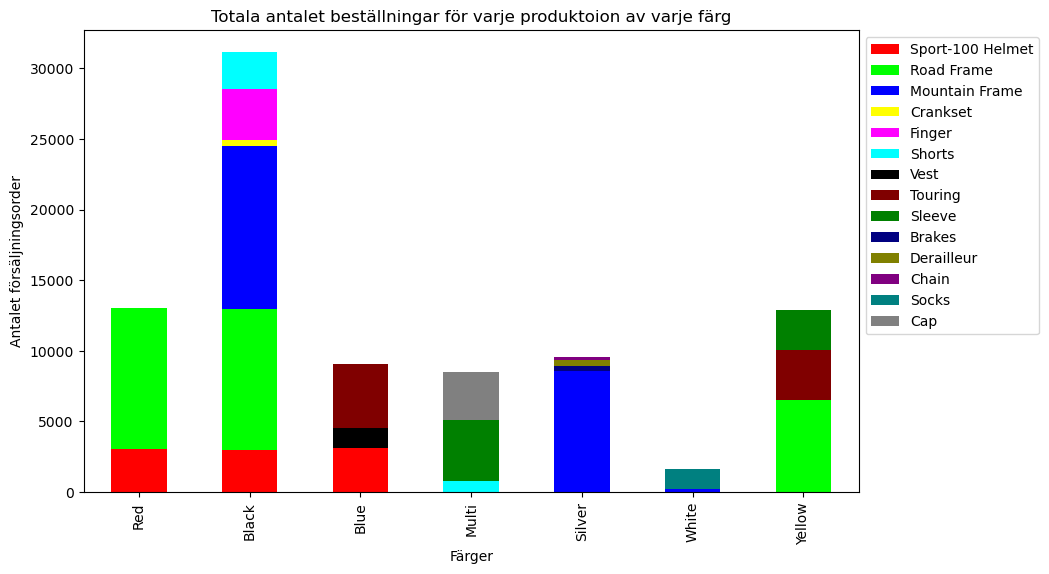

In [52]:
# Visualisera_4 antalet beställningar för varje produktoion av varje färg

# Convert numeric columns to integers
numeric_cols = df2.columns.difference(['Color'])
df2[numeric_cols] = df2[numeric_cols].astype(int)

custom_colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF', '#000000',
                 '#800000', '#008000', '#000080', '#808000', '#800080', '#008080', '#808080']

Product_color = df2.plot(kind='bar', x='Color', stacked=True, color=custom_colors, figsize=(10, 6))

plt.title('Totala antalet beställningar för varje produktoion av varje färg')
plt.xlabel('Färger')
plt.ylabel('Antalet försäljningsorder')
Product_color.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

In [55]:
# Analys fördelning av TotalFörsäljning på olika region Året hittills
query_6 = """
SELECT sp.TerritoryID,
       st.Name AS Country,
       SUM(st.SalesYTD) AS TotalSalesYTD
FROM Sales.SalesPerson AS sp
INNER JOIN Sales.SalesTerritory AS st
       ON sp.TerritoryID = st.TerritoryID
GROUP BY sp.TerritoryID, st.Name
ORDER BY TotalSalesYTD DESC; 
"""

Country
Australia         5.977815e+06
Canada            1.354366e+07
Central           3.072175e+06
France            4.772398e+06
Germany           3.805202e+06
Northeast         2.402177e+06
Northwest         2.366156e+07
Southeast         2.538667e+06
Southwest         2.102171e+07
United Kingdom    5.012905e+06
Name: TotalSalesYTD, dtype: float64


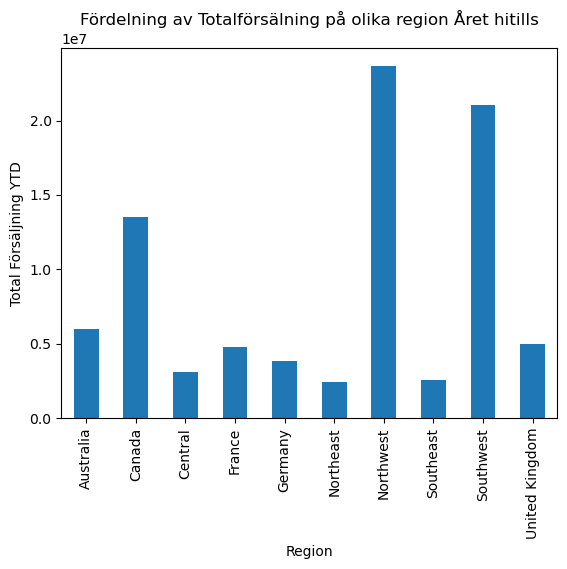

In [56]:
df_TotalSalesYTD = pd.read_sql(query_6, con=connection)

# Beräkna totalförsälning på olika region
TotalSalesYTD_distribution = df_TotalSalesYTD.groupby('Country')['TotalSalesYTD'].sum()
print(TotalSalesYTD_distribution )

TotalSalesYTD_distribution.plot(kind='bar')
plt.title('Fördelning av Totalförsälning på olika region Året hitills')
plt.xlabel('Region')
plt.ylabel('Total Försäljning YTD')
plt.show()

In [57]:
# Filtera ut Customer på olika region
query_7 = """
SELECT
       sc.CustomerID,
       sc.TerritoryID,
       st.Name AS Country
FROM Sales.Customer AS sc
JOIN Sales.SalesTerritory AS st
       ON sc.TerritoryID = st.TerritoryID; 
"""

Country
Australia         3665
Canada            1791
Central            132
France            1884
Germany           1852
Northeast          113
Northwest         3520
Southeast          176
Southwest         4696
United Kingdom    1991
Name: CustomerID, dtype: int64


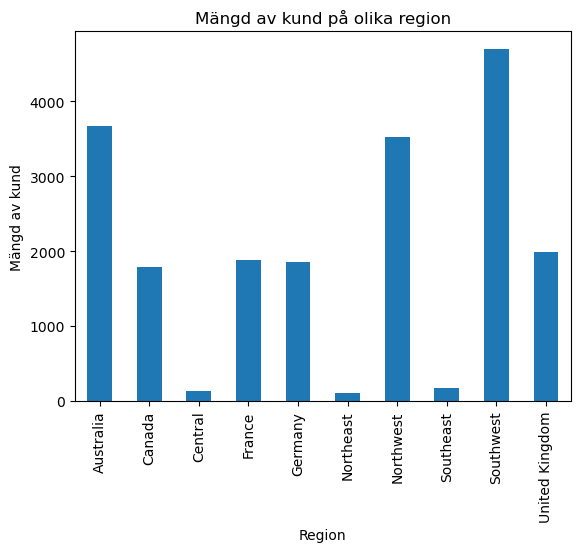

In [198]:
df_TolCustomer = pd.read_sql(query_7, con=connection)

# Beräkna mängd av kund på olika region
TolCustomer = df_TolCustomer.groupby('Country')['CustomerID'].count()
print(TolCustomer )

# Plot 
TolCustomer.plot(kind='bar')
plt.title('Mängd av kund på olika region')
plt.xlabel('Region')
plt.ylabel('Mängd av kund')
plt.show()

In [58]:
# Filtera ut Customer på olika region
query_8 = """
SELECT ProductID, Name,TotalSold,August_Goal,
    CASE
      WHEN TotalSold - August_Goal >= 0 Then 'Complete'
      WHEN TotalSold - August_Goal BETWEEN -3 AND -1 Then 'Almost'
      ELSE 'Unfinished'
    END AS August_Task
FROM Sales.August_Goal_Table
ORDER BY August_Task;
"""

In [37]:
df_Auggoal = pd.read_sql(query_8, con=connection)

df_Auggoal.head(100)

,ProductID,Name,TotalSold,August_Goal,August_Task
0,732,"ML Road Frame - Red, 48",26,29,Almost
1,755,"Road-450 Red, 60",22,24,Almost
2,756,"Road-450 Red, 44",21,23,Almost
3,752,"Road-150 Red, 52",21,23,Almost
4,748,"HL Mountain Frame - Silver, 38",20,22,Almost
5,722,"LL Road Frame - Black, 58",20,22,Almost
6,726,"LL Road Frame - Red, 48",19,21,Almost
7,745,"HL Mountain Frame - Black, 48",19,21,Almost
8,768,"Road-650 Black, 44",19,21,Almost
9,751,"Road-150 Red, 48",18,20,Almost


In [59]:
# Användning av en CTE för att analysera uppgiften Status för slutförande av uppgift i augusti
query_9_cte_goal = """
WITH August_goal_CTE 
AS (
SELECT ProductID, Name,TotalSold,August_Goal,
    CASE
      WHEN TotalSold - August_Goal >= 0 Then 'Complete'
      WHEN TotalSold - August_Goal BETWEEN -3 AND -1 Then 'Almost'
      ELSE 'Unfinished'
    END AS August_Task
FROM Sales.August_Goal_Table
)

SELECT
    August_Task AS AugStatus,
    COUNT(*) AS Task_Count,
    COUNT(*) * 100.0 / SUM(COUNT(*)) OVER () AS TaskProcent
FROM
    August_goal_CTE 
GROUP BY
    August_Task
ORDER BY
    August_Task;
"""

    AugStatus  Task_Count  TaskProcent
0      Almost          20    39.215686
1    Complete           2     3.921569
2  Unfinished          29    56.862745


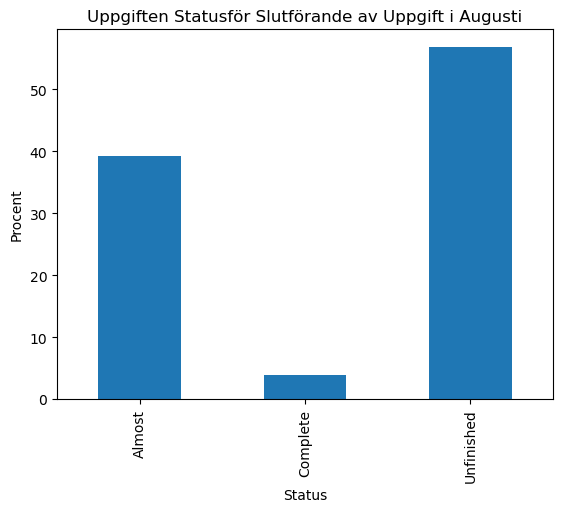

In [39]:
AugStatus = pd.read_sql(query_9_cte_goal, con=connection)
print(AugStatus)

AugStatus.plot(kind='bar', x='AugStatus', y='TaskProcent', legend=False)

plt.title('Uppgiften Statusför Slutförande av Uppgift i Augusti')
plt.xlabel('Status')
plt.ylabel('Procent')

plt.show()